
🔹 KNN
Acurácia média (Validação Cruzada): 53.1% ± 3.7%
Acurácia no conjunto de teste: 52.1%
Classification Report (Teste):
              precision    recall  f1-score   support

           0       0.57      0.24      0.34        49
           1       0.51      0.81      0.62        47

    accuracy                           0.52        96
   macro avg       0.54      0.53      0.48        96
weighted avg       0.54      0.52      0.48        96


🔹 SVM
Acurácia média (Validação Cruzada): 54.2% ± 1.6%
Acurácia no conjunto de teste: 55.2%
Classification Report (Teste):
              precision    recall  f1-score   support

           0       0.65      0.27      0.38        49
           1       0.53      0.85      0.65        47

    accuracy                           0.55        96
   macro avg       0.59      0.56      0.51        96
weighted avg       0.59      0.55      0.51        96


🔹 Random Forest
Acurácia média (Validação Cruzada): 52.1% ± 4.5%
Acurácia no conjunto de teste: 5

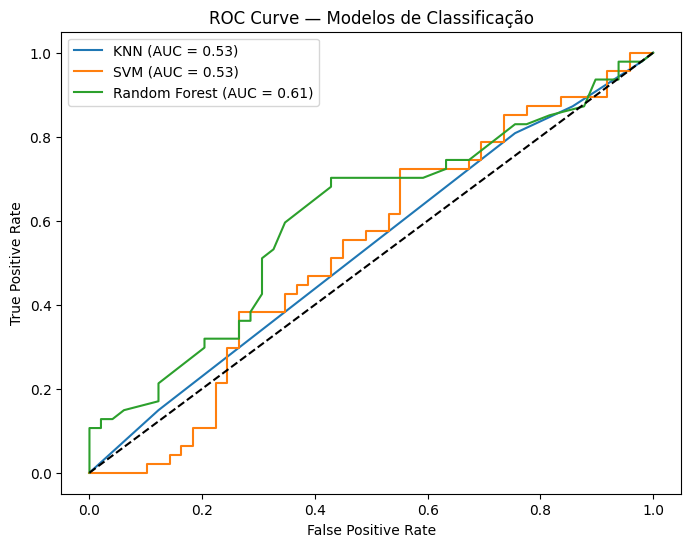


🔮 Previsão para o próximo dia:
O Ibovespa deve subir 📈


In [1]:
# ==========================================================
# PROJETO: Previsão de Movimentos do Ibovespa
# Pós-graduação em Data Analytics — FIAP
# ==========================================================

# 🔹 Importação das bibliotecas principais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    roc_curve,
    auc,
    ConfusionMatrixDisplay,
)
from sklearn.ensemble import RandomForestClassifier

# ==========================================================
# 1️⃣ LEITURA E LIMPEZA DOS DADOS
# ==========================================================

# Lê o CSV exportado do site de cotações
file_path = r"C:\Users\vinic\OneDrive\Área de Trabalho\Vinicius\Data Analytics\Tech Challenge\Fase 02\TechChallengeFase02\Dados Históricos - Ibovespa.csv"

df = pd.read_csv(file_path)

# Renomeia as colunas para facilitar o manuseio
df.columns = ["Date", "Price", "Open", "High", "Low", "Vol", "Change"]



# Converte a coluna "Date" para o formato datetime
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)

# Ordena o dataset da data mais antiga para a mais recente
df = df.sort_values("Date").reset_index(drop=True)

# ==========================================================
# 2️⃣ TRATAMENTO DAS COLUNAS NUMÉRICAS
# ==========================================================

# Função para converter volumes no formato 9.48M, 2.1B etc. para números
def parse_volume(v):
    v = str(v).replace(",", "").strip()
    if v.endswith("M"):  # milhões
        return float(v[:-1]) * 1e6
    elif v.endswith("B"):  # bilhões
        return float(v[:-1]) * 1e9
    elif v.isdigit():  # número puro
        return float(v)
    else:
        return np.nan

# Aplica a conversão à coluna "Vol"
df["Vol"] = df["Vol"].apply(parse_volume)

# Converte “Change” (variação percentual) removendo o símbolo “%”
df["Change"] = (
    df["Change"].astype(str).str.replace("%", "").str.replace(",", ".").astype(float)
)

# Converte colunas de preços em float
for col in ["Price", "Open", "High", "Low"]:
    df[col] = df[col].astype(str).str.replace(".", "").str.replace(",", ".").astype(float)

# ==========================================================
# 3️⃣ FEATURE ENGINEERING (CRIAÇÃO DE VARIÁVEIS)
# ==========================================================

# Cria a variável “Target” (1 = preço subiu, 0 = preço caiu)
df["Target"] = (df["Price"].shift(-1) > df["Price"]).astype(int)

# Calcula retornos diários
df["Return"] = df["Price"].pct_change()

# Médias móveis de curto e longo prazo
df["MA5"] = df["Price"].rolling(window=5).mean()
df["MA20"] = df["Price"].rolling(window=20).mean()

# Remove as linhas com valores NaN (geradas pelas médias móveis)
df = df.dropna()

# ==========================================================
# 4️⃣ SEPARAÇÃO ENTRE TREINO E TESTE
# ==========================================================

X = df[["Open", "High", "Low", "Vol", "Return", "MA5", "MA20"]]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ==========================================================
# 5️⃣ PIPELINES COM DIFERENTES MODELOS
# ==========================================================

# 🔹 Modelo 1: KNN
pipe_knn = Pipeline(
    [
        ("scaler", StandardScaler()),  # Normaliza os dados
        ("model", KNeighborsClassifier(n_neighbors=5)),
    ]
)

# 🔹 Modelo 2: SVM
pipe_svm = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("model", SVC(kernel="rbf", probability=True, random_state=42)),
    ]
)

# 🔹 Modelo 3: Random Forest
pipe_rf = Pipeline([("model", RandomForestClassifier(random_state=42))])

# ==========================================================
# 6️⃣ AVALIAÇÃO COM VALIDAÇÃO CRUZADA (formato em %)
# ==========================================================

def evaluate_model(pipe, name):
    """Executa validação cruzada e mostra métricas em %."""
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="accuracy")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    # Acurácia no conjunto de teste
    test_accuracy = pipe.score(X_test, y_test)
    
    # Converte para porcentagem
    cv_mean = scores.mean() * 100
    cv_std = scores.std() * 100
    test_acc_percent = test_accuracy * 100
    
    print(f"\n🔹 {name}")
    print(f"Acurácia média (Validação Cruzada): {cv_mean:.1f}% ± {cv_std:.1f}%")
    print(f"Acurácia no conjunto de teste: {test_acc_percent:.1f}%")
    print("Classification Report (Teste):")
    print(classification_report(y_test, y_pred))
    
    return {"modelo": name, "cv_acc": cv_mean, "test_acc": test_acc_percent}

# Executa os três modelos e armazena resultados
results = [
    evaluate_model(pipe_knn, "KNN"),
    evaluate_model(pipe_svm, "SVM"),
    evaluate_model(pipe_rf, "Random Forest"),
]

# Mostra um resumo final com os valores em %
print("\n📊 Resumo das Acurácias:")
for r in results:
    print(f"{r['modelo']}: CV = {r['cv_acc']:.1f}% | Teste = {r['test_acc']:.1f}%")


# ==========================================================
# 7️⃣ CURVA ROC E AUC SCORE
# ==========================================================

plt.figure(figsize=(8, 6))
for name, model in {
    "KNN": pipe_knn,
    "SVM": pipe_svm,
    "Random Forest": pipe_rf,
}.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Linha de referência (azar)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Modelos de Classificação")
plt.legend()
plt.show()

# ==========================================================
# 8️⃣ FORECASTING (PREVISÃO FUTURA SIMPLES)
# ==========================================================

# Neste caso, fazemos uma previsão do próximo dia usando o melhor modelo (Random Forest)
next_day = df.iloc[-1:].copy()
next_day_features = next_day[["Open", "High", "Low", "Vol", "Return", "MA5", "MA20"]]

# Predição do movimento do próximo pregão
future_pred = pipe_rf.predict(next_day_features)[0]
print("\n🔮 Previsão para o próximo dia:")
print("O Ibovespa deve subir 📈" if future_pred == 1 else "O Ibovespa deve cair 📉")
